In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from cartopy import crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as ticker
import glob

In [5]:
epath = '/disco/share/sh1293/EMARS_data/Isentropic/'
opath = '/disco/share/sh1293/OpenMars_data/Isentropic/'
path = opath
my = str(32)

/disco/share/sh1293/OpenMars_data/Isentropic/isentropic_openmars_my32_ls300_my32_ls318.nc


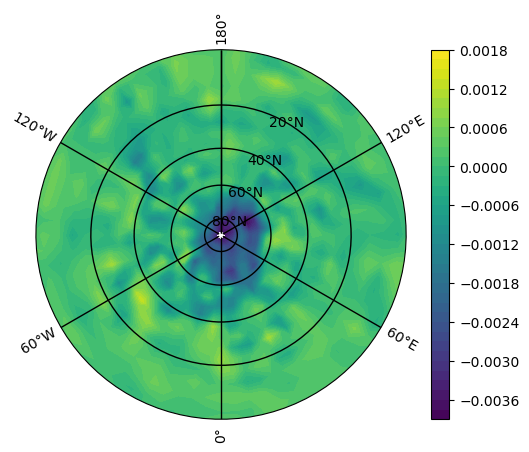

/disco/share/sh1293/OpenMars_data/Isentropic/isentropic_openmars_my32_ls281_my32_ls300.nc


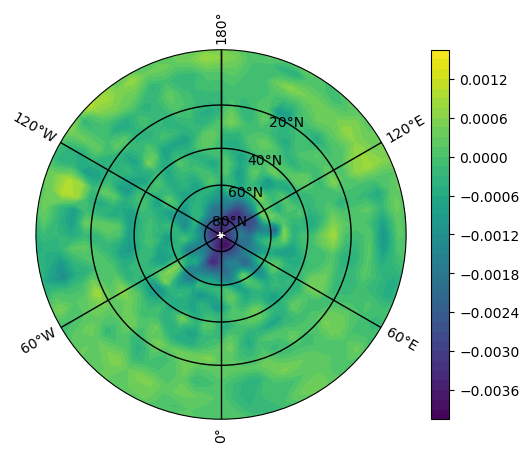

In [6]:
files = glob.glob(path + '*' + my + '_*.nc')
for file in files:
    print(file)
    ds = xr.open_dataset(file, engine = 'netcdf4')
    times = np.linspace(0,len(ds.time)-1, len(ds.time))
    ds = ds.assign_coords(time=times)
    #ds['PVs'] = ds.PV * (ds.ilev/200)**(-(1+4))
    timeind = -1
    isenind = -5
    latind = 10
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180,180,00,90], crs=ccrs.PlateCarree())
    #ds.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
    plot = ax.contourf(ds.PV[timeind, isenind, :].lon, ds.PV[timeind, isenind, :].lat,
                ds.PV[timeind, isenind, :], transform = ccrs.PlateCarree(), levels = 42)
    plt.colorbar(plot, ax = ax)
    #plt.title('PV at %.0fK level at L_s = %.2f' %(ds.ilev.values[isenind], float(ds.Ls.values[0,timeind])))
    plt.show()
    #plt.savefig(file + '.png', bbox_inches = 'tight')

/disco/share/sh1293/OpenMars_data/Isentropic/isentropic_openmars_my32_ls300_my32_ls318.nc
/disco/share/sh1293/OpenMars_data/Isentropic/isentropic_openmars_my32_ls281_my32_ls300.nc


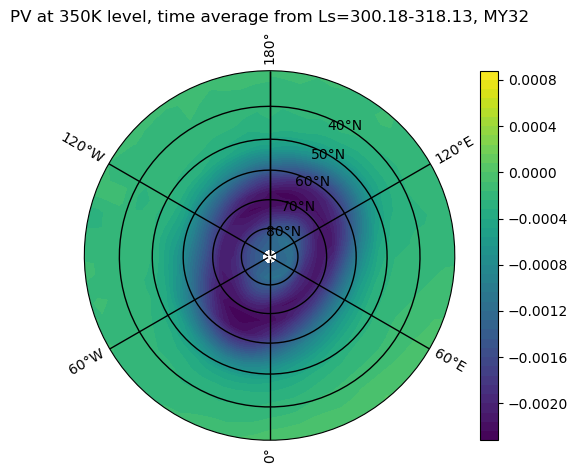

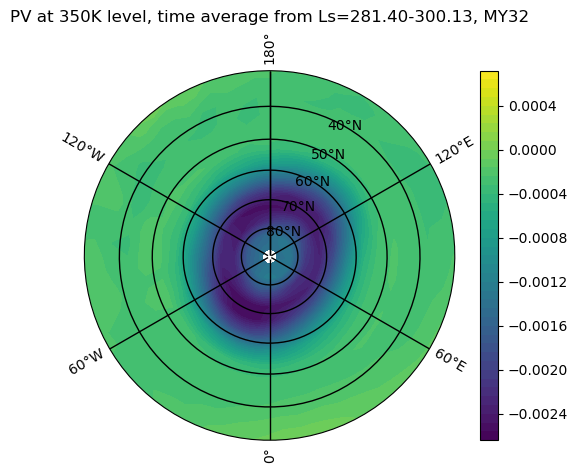

In [7]:
files = glob.glob(path + '*my' + my + '*.nc')
for file in files:
    print(file)
    ds = xr.open_dataset(file, engine = 'netcdf4')
    times = np.linspace(0,len(ds.time)-1, len(ds.time))
    ds = ds.assign_coords(time=times)
    ds['PVs'] = ds.uwnd * (ds.ilev/200)**(-(1+4))
    time_average = ds.mean(dim = 'time')
    isenind = 3
    latind = 8
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180,180,30,90], crs=ccrs.PlateCarree())
    #time_average.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
    plot = ax.contourf(time_average.PV[isenind, :].lon, time_average.PV[isenind, :].lat,
                time_average.PV[isenind, :], transform = ccrs.PlateCarree(), levels = 42)
    plt.title('PV at %.0fK level, time average from Ls=%.2f-%.2f, MY%.0f' %(time_average.ilev.values[isenind],
                                                                        ds.Ls.values[0][0], ds.Ls.values[0][-1], int(my)))
    plt.colorbar(plot, ax=ax)
    plt.savefig('/home/links/sh1293/Reanalysis/Ls_' + str(ds.Ls.values[0][0]) + ' PV_new.png', bbox_inches = 'tight')

In [5]:
def wrapped_gradient(da, coord):
    '''
    Finds the gradient along a given dimension of a dataarray.
    Input
    -----
    da    : array-like
    coord : dimension name for axis along which to take gradient
    '''

    dims_of_coord = da.coords[coord].dims
    if len(dims_of_coord) == 1:
        dim = dims_of_coord[0]
    else:
        raise ValueError('Coordinate ' + coord + ' has multiple dimensions: ' + str(dims_of_coord))

    coord_vals = da.coords[coord].values

    return xr.apply_ufunc(np.gradient, da, coord_vals, kwargs={'axis': -1},
                          input_core_dims=[[dim], [dim]],
                          output_core_dims=[[dim]],
                          dask='parallelized',
                          output_dtypes=[da.dtype])

In [66]:
from windspharm.xarray import VectorWind

rsphere = 3.3962e6
omega = 7.08822e-05
g = 3.72076

w = VectorWind(ds.uwnd.fillna(0), ds.vwnd.fillna(0), rsphere = rsphere)

relvort = w.vorticity()
relvort = relvort.where(relvort!=0, other=np.nan)
planvort = w.planetaryvorticity(omega=omega)
absvort = relvort + planvort

dthtadx, dthtady = w.gradient(ds.theta.fillna(0))
dthtadx = dthtadx.where(dthtadx!=0, other=np.nan)
dthtady = dthtady.where(dthtady!=0, other=np.nan)

coord = 'plev'

dthtadp = wrapped_gradient(ds.theta, coord)
dudp = wrapped_gradient(ds.uwnd, coord)
dvdp = wrapped_gradient(ds.vwnd, coord)

s = -dthtadp
f = dvdp * dthtadx - dudp * dthtady
ret  = g * (absvort + f/s) * s

In [2]:
path1 = '/disco/share/sh1293/EMARS_data/Regrid/'
files1 = glob.glob(path1 + '*.nc')
for file1 in files1:
    ds1 = xr.open_dataset(file1, engine = 'netcdf4')

In [3]:
ds1

<xarray.Dataset>
Dimensions:               (time: 1104, lon: 72, lat: 36, pfull: 28, phalf: 29)
Coordinates:
  * time                  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * lon                   (lon) float32 -180.0 -175.0 -170.0 ... 170.0 175.0
  * lat                   (lat) float32 87.5 82.5 77.5 ... -77.5 -82.5 -87.5
  * pfull                 (pfull) float64 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 0.0002 0.0005738 ... 7.648 7.7
Data variables: (12/19)
    Ls                    (time) float64 ...
    MY                    (time) float64 ...
    Surface_geopotential  (lat, lon) float64 ...
    T                     (time, pfull, lat, lon) float64 ...
    U                     (time, pfull, lat, lon) float64 ...
    V                     (time, pfull, lat, lon) float64 ...
    ...                    ...
    earth_year            (time) float64 ...
    emars_sol             (time) float64 ...
    macda_sol             (time) float64 ...
    mars_hour             (time) float64 ...
    mars_soy              (time) float64 ...
    ps                    (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Nov 15 16:16:55 2023: cdo remapcon,/disco/share/sh1293/...
    CDO:          Climate Data Operators version 1.9.7 (http://mpimet.mpg.de/...

In [13]:
times = np.linspace(0,len(ds1.time)-1, len(ds1.time))
ds1 = ds1.assign_coords(time=times)

In [14]:
times

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.101e+03, 1.102e+03,
       1.103e+03])

In [15]:
ds1 = ds1.assign_coords(time=times)

In [16]:
ds1

<xarray.Dataset>
Dimensions:               (lon: 72, lat: 36, pfull: 28, phalf: 29, time: 1104)
Coordinates:
  * lon                   (lon) float32 -180.0 -175.0 -170.0 ... 170.0 175.0
  * lat                   (lat) float32 87.5 82.5 77.5 ... -77.5 -82.5 -87.5
  * pfull                 (pfull) float64 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 0.0002 0.0005738 ... 7.648 7.7
  * time                  (time) float64 0.0 1.0 2.0 ... 1.102e+03 1.103e+03
Data variables: (12/19)
    Ls                    (time) float64 ...
    MY                    (time) float64 ...
    Surface_geopotential  (lat, lon) float64 ...
    T                     (time, pfull, lat, lon) float64 ...
    U                     (time, pfull, lat, lon) float64 ...
    V                     (time, pfull, lat, lon) float64 ...
    ...                    ...
    earth_year            (time) float64 ...
    emars_sol             (time) float64 ...
    macda_sol             (time) float64 ...
    mars_hour             (time) float64 ...
    mars_soy              (time) float64 ...
    ps                    (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Nov 15 16:16:55 2023: cdo remapcon,/disco/share/sh1293/...
    CDO:          Climate Data Operators version 1.9.7 (http://mpimet.mpg.de/...

In [5]:
ds1.T[0,0,0,:]

<xarray.DataArray 'T' (lon: 72)>
[72 values with dtype=float64]
Coordinates:
    pfull    float64 0.0003547
    time     float64 0.0
    lat      float32 87.5
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
Attributes:
    long_name:  Temperature
    units:      K

### remapcon

In [31]:
ds1

<xarray.Dataset>
Dimensions:               (time: 1104, lon: 72, lat: 36, pfull: 28, phalf: 29)
Coordinates:
  * time                  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * lon                   (lon) float32 -180.0 -175.0 -170.0 ... 170.0 175.0
  * lat                   (lat) float32 87.5 82.5 77.5 ... -77.5 -82.5 -87.5
  * pfull                 (pfull) float64 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 0.0002 0.0005738 ... 7.648 7.7
Data variables: (12/19)
    Ls                    (time) float64 ...
    MY                    (time) float64 ...
    Surface_geopotential  (lat, lon) float64 ...
    T                     (time, pfull, lat, lon) float64 ...
    U                     (time, pfull, lat, lon) float64 ...
    V                     (time, pfull, lat, lon) float64 ...
    ...                    ...
    earth_year            (time) float64 ...
    emars_sol             (time) float64 ...
    macda_sol             (time) float64 ...
    mars_hour             (time) float64 ...
    mars_soy              (time) float64 ...
    ps                    (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Nov 14 11:49:33 2023: cdo remapcon,/disco/share/sh1293/...
    CDO:          Climate Data Operators version 1.9.7 (http://mpimet.mpg.de/...

### raw

In [29]:
ds1

<xarray.Dataset>
Dimensions:               (time: 1104, lat: 36, lon: 60, pfull: 28, latu: 36,
                           lonv: 60, phalf: 29)
Coordinates:
  * lat                   (lat) float64 -88.71 -84.86 -79.71 ... 84.86 88.71
  * latu                  (latu) float64 -87.43 -87.43 -82.29 ... 82.29 87.43
  * lon                   (lon) float64 3.0 9.0 15.0 21.0 ... 345.0 351.0 357.0
  * lonv                  (lonv) float64 0.0 6.0 12.0 18.0 ... 342.0 348.0 354.0
  * pfull                 (pfull) float64 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 0.0002 0.0005738 ... 7.648 7.7
  * time                  (time) float64 0.0 1.0 2.0 ... 1.102e+03 1.103e+03
Data variables: (12/19)
    Ls                    (time) float64 ...
    MY                    (time) float64 ...
    Surface_geopotential  (lat, lon) float64 ...
    T                     (time, pfull, lat, lon) float64 ...
    U                     (time, pfull, latu, lon) float64 ...
    V                     (time, pfull, lat, lonv) float64 ...
    ...                    ...
    earth_year            (time) float64 ...
    emars_sol             (time) float64 ...
    macda_sol             (time) float64 ...
    mars_hour             (time) float64 ...
    mars_soy              (time) float64 ...
    ps                    (time, lat, lon) float64 ...

### save_grid.py remap

In [27]:
ds1

<xarray.Dataset>
Dimensions:               (time: 1104, lat: 36, lon: 72, pfull: 28, latu: 36,
                           lonv: 60, phalf: 29)
Coordinates:
  * latu                  (latu) float64 -87.43 -87.43 -82.29 ... 82.29 87.43
  * lonv                  (lonv) float64 0.0 6.0 12.0 18.0 ... 342.0 348.0 354.0
  * pfull                 (pfull) float64 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 0.0002 0.0005738 ... 7.648 7.7
  * time                  (time) float64 0.0 1.0 2.0 ... 1.102e+03 1.103e+03
  * lat                   (lat) float32 87.5 82.5 77.5 ... -77.5 -82.5 -87.5
  * lon                   (lon) float32 -180.0 -175.0 -170.0 ... 170.0 175.0
Data variables: (12/19)
    Ls                    (time) float64 ...
    MY                    (time) float64 ...
    Surface_geopotential  (lat, lon) float64 ...
    T                     (time, pfull, lat, lon) float64 ...
    U                     (time, pfull, latu, lon) float64 ...
    V                     (time, pfull, lat, lonv) float64 ...
    ...                    ...
    earth_year            (time) float64 ...
    emars_sol             (time) float64 ...
    macda_sol             (time) float64 ...
    mars_hour             (time) float64 ...
    mars_soy              (time) float64 ...
    ps                    (time, lat, lon) float64 ...

In [96]:
time_average.uwnd

<xarray.DataArray 'uwnd' (ilev: 16, lat: 36, lon: 73)>
array([[[-1.08822450e-03, -1.08843581e-03, -1.08868169e-03, ...,
         -1.08794278e-03, -1.08804696e-03, -1.08820894e-03],
        [-1.16838923e-03, -1.16891431e-03, -1.16850732e-03, ...,
         -1.16049357e-03, -1.16399160e-03, -1.16644167e-03],
        [-1.18099121e-03, -1.18919706e-03, -1.19880709e-03, ...,
         -1.16751134e-03, -1.17028301e-03, -1.17442459e-03],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.20407718e-03, -1.20409440e-03, -1.20410239e-03, ...,
         -1.20399783e-03, -1.20403218e-03, -1.20406062e-03],
        [-1.25269852e-03, -1.25743466e-03, -1.26162502e-03, ...,
         -1.23401082e-03, -1.24092175e-03, -1.24707212e-03],
        [-1.33954129e-03, -1.35928469e-03, -1.38054575e-03, ...,
         -1.29412647e-03, -1.30648744e-03, -1.32091646e-03],
...
        [ 1.95050677e-04,  1.94078998e-04,  1.92811915e-04, ...,
          1.91507196e-04,  1.94196459e-04,  1.95374312e-04],
        [-5.64804085e-05, -5.00664216e-05, -4.38978742e-05, ...,
         -7.37605061e-05, -6.84102551e-05, -6.25811088e-05],
        [-2.64995543e-04, -2.65129578e-04, -2.65266418e-04, ...,
         -2.64649539e-04, -2.64810545e-04, -2.64965327e-04]],

       [[-4.39024139e-03, -4.38916765e-03, -4.38836437e-03, ...,
         -4.39314485e-03, -4.39155574e-03, -4.39014086e-03],
        [-3.40426459e-03, -3.37213460e-03, -3.34078006e-03, ...,
         -3.49742187e-03, -3.46522376e-03, -3.43225908e-03],
        [-2.46576612e-03, -2.42184718e-03, -2.38458918e-03, ...,
         -2.64006177e-03, -2.57473487e-03, -2.51504559e-03],
        ...,
        [ 2.11748840e-04,  2.11775138e-04,  2.10973789e-04, ...,
          2.07220274e-04,  2.09870973e-04,  2.11457194e-04],
        [-5.10834494e-05, -4.51064240e-05, -3.93721108e-05, ...,
         -6.95441164e-05, -6.33012429e-05, -5.69218729e-05],
        [-2.56112222e-04, -2.56230895e-04, -2.56302221e-04, ...,
         -2.55678234e-04, -2.55888026e-04, -2.56074710e-04]]])
Coordinates:
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * ilev     (ilev) float64 200.0 250.0 300.0 350.0 ... 800.0 850.0 900.0 950.0

In [157]:
process = xr.open_dataset('/disco/share/sh1293/OpenMars_data/Isentropic/isentropic_openmars_my32_ls300_my32_ls318.nc')
raw = xr.open_dataset('/disco/share/sh1293/OpenMars_data/openmars_my32_ls300_my32_ls318.nc')
raw.u[-1,2,:,0].values

array([ -6.722328  ,  -8.486895  ,  -6.628283  ,  -1.1416882 ,
         7.6953654 ,  15.127833  ,  15.841011  ,  19.75881   ,
        17.251596  ,  11.563636  ,   4.127593  ,   3.920164  ,
         3.9202163 ,  -0.10142273,  -2.7234607 ,  -7.5286436 ,
       -11.968146  , -11.49606   ,  -7.3322883 ,   0.02805907,
         8.236095  ,  15.400084  ,  20.638937  ,  23.694988  ,
        20.503838  ,  10.006536  ,   2.1048589 ,  -1.558572  ,
        -2.6423967 ,  -2.9976742 ,  -2.4195378 ,   0.52591985,
         3.2896736 ,   3.0415707 ,  -2.0373197 ,  -3.6857677 ],
      dtype=float32)

In [158]:
process.tmp[-1,2,:,0].values

array([ -0.92571009,   6.30422925,  26.89936269,  58.38592897,
        76.95524446,  77.616288  ,  91.80151167,  91.95211409,
        84.24603241,  71.16266809,  60.83521715,  50.59490914,
        37.56802312,  26.47413977,  19.59348078,  13.93827343,
         5.16679171,   0.58327211,   2.7758158 ,  -7.19973409,
       -16.87025224, -14.45551689, -16.16745308, -17.91513841,
       -12.67633156, -10.62191916, -10.22275411,  -9.16020878,
        -9.61618614,  -7.75676766,  -0.90086014,   5.5479198 ,
         4.07626085,  -0.99001443,  -3.85514569,  -3.45059922])

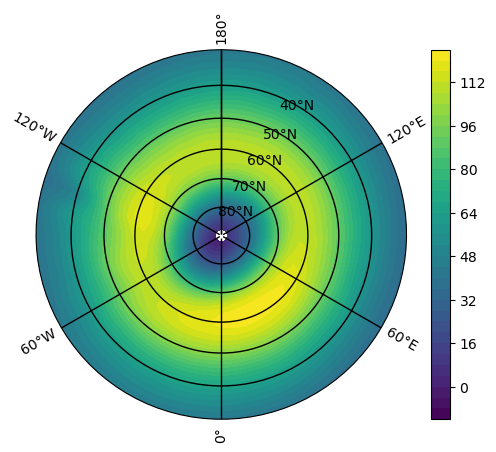

In [90]:
empath = '/disco/share/sh1293/Emily_data/MY32_Ls270-300_300K.nc'
d = xr.open_dataset(empath)
#d = d.where(d.Ls >= 270, drop = True)
#d = d.where(d.Ls <= 300, drop = True)
d = d.mean(dim = 'new_time')
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180,180,30,90], crs=ccrs.PlateCarree())
#d.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
plot = ax.contourf(d.PV[4, :, :, 0].lon, d.PV[4, :, :, 0].lat,
            d.uwnd[4, :, :, 0], transform = ccrs.PlateCarree(), levels = 42)
plt.colorbar(plot, ax = ax)
#plt.title('PV at %.0fK level at L_s = %.2f' %(d.ilev.values[isenind], float(d.Ls.values[0,timeind])))
plt.show()

In [80]:
empath = '/disco/share/sh1293/Emily_data/MY32_Ls270-300_300K.nc'
d = xr.open_dataset(empath)

In [86]:
d.uwnd

<xarray.DataArray 'uwnd' (ilev: 34, lat: 32, lon: 129, MY: 2)>
array([[[[-3.52216631e-01,  5.41228056e-01],
         [-2.87102200e-02,  8.33367527e-01],
         [ 3.04222584e-01,  1.13264406e+00],
         ...,
         [-9.64344680e-01, -1.56557970e-02],
         [-6.64631069e-01,  2.57732064e-01],
         [-3.52216631e-01,  5.41228056e-01]],

        [[ 2.94515538e+00,  3.13079381e+00],
         [ 3.37074900e+00,  3.53481793e+00],
         [ 3.80922174e+00,  3.95127845e+00],
         ...,
         [ 2.14701796e+00,  2.37419963e+00],
         [ 2.53605580e+00,  2.74276185e+00],
         [ 2.94515538e+00,  3.13079381e+00]],

        [[ 7.64499092e+00,  7.38965034e+00],
         [ 8.11449718e+00,  7.87458229e+00],
         [ 8.59683037e+00,  8.37453175e+00],
         ...,
...
         ...,
         [            nan,             nan],
         [            nan,             nan],
         [            nan,             nan]],

        [[            nan,             nan],
         [            nan,             nan],
         [            nan,             nan],
         ...,
         [            nan,             nan],
         [            nan,             nan],
         [            nan,             nan]],

        [[            nan,             nan],
         [            nan,             nan],
         [            nan,             nan],
         ...,
         [            nan,             nan],
         [            nan,             nan],
         [            nan,             nan]]]], dtype=float32)
Coordinates:
  * MY           (MY) int64 0 1
    scalar_axis  float64 ...
  * ilev         (ilev) float64 200.0 225.0 250.0 275.0 ... 850.0 900.0 950.0
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2 360.0
  * lat          (lat) float64 87.86 85.1 82.31 79.53 ... 6.977 4.186 1.395

### remapcon

In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 1104, ilev: 16, lat: 36, lon: 73)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.101e+03 1.102e+03 1.103e+03
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * ilev     (ilev) float64 200.0 250.0 300.0 350.0 ... 800.0 850.0 900.0 950.0
Data variables:
    prs      (time, ilev, lat, lon) float64 ...
    PV       (time, ilev, lat, lon) float64 ...
    uwnd     (time, ilev, lat, lon) float64 ...
    tmp      (time, ilev, lat, lon) float64 ...
    Ls       (lon, time) float32 ...
    MY       (lon, time) float32 ...

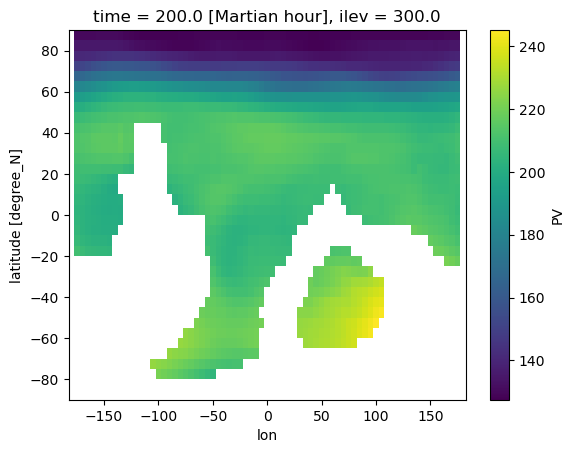

In [7]:
ds.PV[200, 2].plot()

In [14]:
ds.PV[200,2,8].values

array([         nan, 206.67393132, 207.78956525, 208.53695659,
       209.58520418, 209.97209434, 210.55064665, 211.09580231,
       211.41399217, 211.77035234, 212.32184282, 212.18549991,
       212.67799278, 213.15064543, 212.62502534, 212.0898276 ,
       211.61450702, 210.62206249, 209.80861708, 209.46582204,
       209.42998049, 209.51160813, 209.96078757, 210.31602883,
       210.63837453, 211.16563207, 211.73757369, 212.08758777,
       212.43384681, 212.78608453, 212.9704604 , 212.91018488,
       212.67941119, 212.60096667, 212.23842715, 211.99048528,
       211.64293699, 211.20224013, 210.7130276 , 210.38292848,
       209.8310963 , 209.2748971 , 208.54605415, 207.76502125,
       207.11720012, 206.50521246, 205.95164227, 205.49341369,
       205.25349002, 205.14833299, 205.03210146, 204.89757213,
       204.85398171, 204.69990983, 204.55071705, 204.41015945,
       204.27076786, 204.22000973, 204.12556249, 204.06762988,
       203.93069962, 203.58952451, 203.02018562, 202.41

In [37]:
ds['PVs'] = ds.PV * (ds.ilev/200)**(-(1+4))

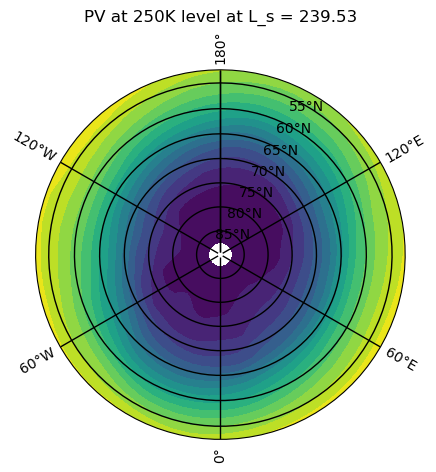

<Figure size 640x480 with 0 Axes>

In [49]:
timeind = 0
isenind = 1
latind = 8
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
ax.set_boundary(circle, transform=ax.transAxes)
#ax.set_extent([-180,180,50,90], crs=ccrs.PlateCarree())
#ds.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
ax.contourf(ds.PV[timeind, isenind, :latind].lon, ds.PV[timeind, isenind, :latind].lat,
            ds.PVs[timeind, isenind, :latind], transform = ccrs.PlateCarree(), levels = 21)
plt.title('PV at %.0fK level at L_s = %.2f' %(ds.ilev.values[isenind], float(ds.Ls.values[0,timeind])))
plt.show()
plt.savefig('random.png', bbox_inches = 'tight')

In [41]:
ds.PV-ds.PVs

<xarray.DataArray (time: 1104, ilev: 16, lat: 36, lon: 73)>
array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[ 89.96619399,  90.00766625,  90.03809144, ...,  89.88745819,
           89.92266127,  89.96619399],
         [ 90.24407117,  90.32849098,  90.40514477, ...,  90.06067161,
           90.15409621,  90.24407117],
         [ 90.96306585,  91.01991033,  91.09466911, ...,  90.82209515,
           90.90485801,  90.96306585],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[179.63948677, 180.5791982 , 181.36242928, ..., 177.36826721,
          178.55878852, 179.63948677],
         [189.23457974, 190.37518124, 191.44327366, ..., 186.60237385,
          187.98716273, 189.23457974],
         [198.06130964, 197.38021116, 196.45495219, ..., 198.48706826,
          198.44861896, 198.06130964],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * ilev     (ilev) float64 200.0 250.0 300.0 350.0 ... 800.0 850.0 900.0 950.0
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.101e+03 1.102e+03 1.103e+03

In [32]:
ds.Ls.values[0,timeind]

239.53

In [22]:
ds.time.values[timeind]

0.0

In [94]:
plt.savefig('random.

<Figure size 640x480 with 0 Axes>

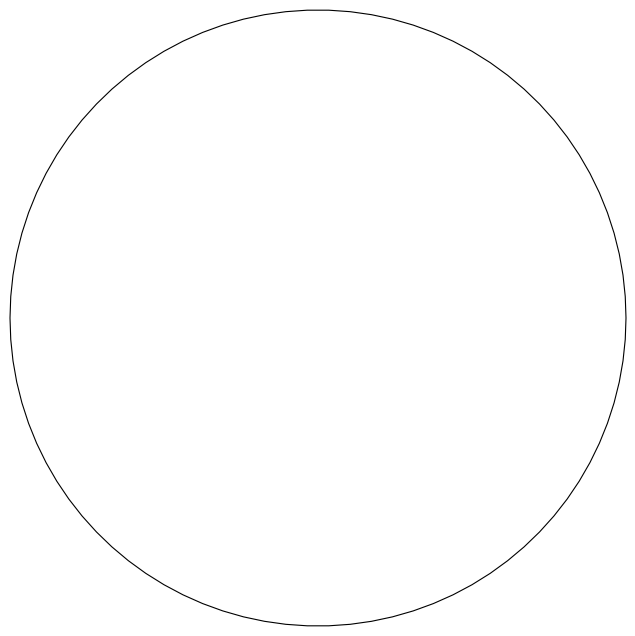

In [36]:
fig, axs = plt.subplots(nrows=1,ncols=1, figsize = (8,8), subplot_kw = {'projection':ccrs.NorthPolarStereo()})

In [37]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [49]:
ds.PV[200, 2]

<xarray.DataArray 'PV' (lat: 36, lon: 73)>
[2628 values with dtype=float64]
Coordinates:
    time     float64 0.0
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
    ilev     float64 300.0

In [51]:
linewidth = 1
linestyle = '-'
color = 'black'
alpha = 1

for j, ax in enumerate(fig.axes):
    print(j)
    gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = linewidth,
                      linestyle = linestyle, color = color, alpha = alpha)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.contourf(ds.lon, ds.lat, ds.PV[200, 2], transform=ccrs.PlateCarree())
    plt.savefig('/home/links/sh1293/Reanalysis/trial_plot.png')

0


<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize = (8, 8))
ax = plt.subplot(111, projection = ccrs.NorthPolarStereo)
pcm = ax.contourf(ds.lon, ds.lat, ds.PV[20000], transform=ccrs.PlateCarree())

TypeError: _as_mpl_axes() missing 1 required positional argument: 'self'

<Figure size 800x800 with 0 Axes>

In [20]:
theta

<xarray.DataArray 'lon' (lon: 74)>
array([-3.14159265, -3.05432619, -2.96705946, -2.879793  , -2.7925268 ,
       -2.70526034, -2.61799388, -2.53072742, -2.44346095, -2.35619449,
       -2.26892803, -2.18166156, -2.0943951 , -2.00712864, -1.91986218,
       -1.83259571, -1.74532925, -1.65806279, -1.57079633, -1.48352973,
       -1.3962634 , -1.30899694, -1.22173048, -1.13446401, -1.04719755,
       -0.95993109, -0.87266463, -0.78539816, -0.6981317 , -0.61086524,
       -0.52359878, -0.43633231, -0.34906585, -0.26179939, -0.17453293,
       -0.08726646,  0.        ,  0.08726646,  0.17453293,  0.26179939,
        0.34906585,  0.43633231,  0.52359878,  0.61086524,  0.6981317 ,
        0.78539816,  0.87266463,  0.95993109,  1.04719755,  1.13446401,
        1.22173048,  1.30899694,  1.3962634 ,  1.48352986,  1.57079633,
        1.65806279,  1.74532925,  1.83259571,  1.91986218,  2.00712864,
        2.0943951 ,  2.18166156,  2.26892803,  2.35619449,  2.44346095,
        2.53072742,  2.61799388,  2.70526034,  2.7925268 ,  2.87979327,
        2.96705973,  3.05432619,  3.14159052,  3.14159091])
Coordinates:
    variable  object ...
  * lon       (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 175.0 180.0 180.0
    ilev      float64 ...

In [44]:
ds.time

<xarray.DataArray 'time' (time: 96600)>
array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.557e+03, 1.558e+03, 1.559e+03])
Coordinates:
    variable  object ...
    ilev      float64 ...
  * time      (time) float64 0.0 1.0 2.0 3.0 ... 1.557e+03 1.558e+03 1.559e+03
Attributes:
    long_name:       number of hours since start of file
    units:           Martian hour
    cartesian_axis:  T
    calendar_type:   NO_CALENDAR
    calendar:        NO_CALENDAR